In [24]:
!pip install adjdatatools

import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from datetime import timedelta

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize


from google.colab import drive
import matplotlib.pyplot as plt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [25]:
# load data
import zipfile

drive.mount('/content/drive')

data_zip = zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/case2_data.zip')
data_zip.extractall('/content/drive/My Drive/Colab Notebooks/')

dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/case2_data.csv')
dataset.time = pd.to_datetime(dataset.time)
print(dataset)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                       time  src_ip  requests
0       2021-03-31 13:53:30   25831         2
1       2021-03-31 13:53:30   93262         8
2       2021-03-31 10:55:00     618         5
3       2021-03-31 10:55:00     716        15
4       2021-03-31 10:55:00    1724         2
...                     ...     ...       ...
1264807 2021-03-31 09:41:30  105247        38
1264808 2021-03-31 09:41:30  106205         6
1264809 2021-03-31 09:41:30  106230         5
1264810 2021-03-31 09:41:30  106414        14
1264811 2021-03-31 09:41:30  106455         5

[1264812 rows x 3 columns]


In the request data, you need to find abnormal client behavior. By abnormal behavior, we mean a high number of requests, both in general and in short periods of time, or a small but constant activity.


In [32]:
# Let's collect basic statistics of user behavior(the number of their requests, 
# the maximum number of requests within thirty seconds, 
# and the total number of time periods during which users made requests)

clients_statistic = pd.DataFrame(columns=["max_requests_in_30s", "requests_count", "time_slots_count"])

g = dataset.sort_values(by="requests", ascending=False).groupby("src_ip")
clients_statistic.time_slots_count = g["time"].count()
clients_statistic.requests_count = g["requests"].sum()
clients_statistic.max_requests_in_30s = g["requests"].first()

print(clients_statistic)

print("----- time_slots_count count for ip ")
print(f"Time slots count mean = {clients_statistic.time_slots_count.mean()}")
print(f"Time slots count std = {clients_statistic.time_slots_count.std()}")
print(f"Time slots count max = {clients_statistic.time_slots_count.max()}")

print("----- request count for ip ")
print(f"Requests count mean = {clients_statistic.requests_count.mean()}")
print(f"Requests count std = {clients_statistic.requests_count.std()}")
print(f"Requests count max = {clients_statistic.requests_count.max()}")

print("----- Max requests in 30s for ip ")
print(f"Max requests in 30s mean = {clients_statistic.max_requests_in_30s.mean()}")
print(f"Max requests in 30s std = {clients_statistic.max_requests_in_30s.std()}")
print(f"Max requests in 30s max = {clients_statistic.max_requests_in_30s.max()}")


        max_requests_in_30s  requests_count  time_slots_count
src_ip                                                       
0                        14              68                11
1                        33              49                 5
2                        11              13                 3
3                         8              10                 3
4                        14              28                 3
...                     ...             ...               ...
106741                   40              70                 2
106742                    9              17                 3
106743                   75             272                14
106744                    1               2                 2
106745                   14              29                 3

[106746 rows x 3 columns]
----- time_slots_count count for ip 
Time slots count mean = 11.848799955033444
Time slots count std = 41.876593527856585
Time slots count max = 3072
----- request cou

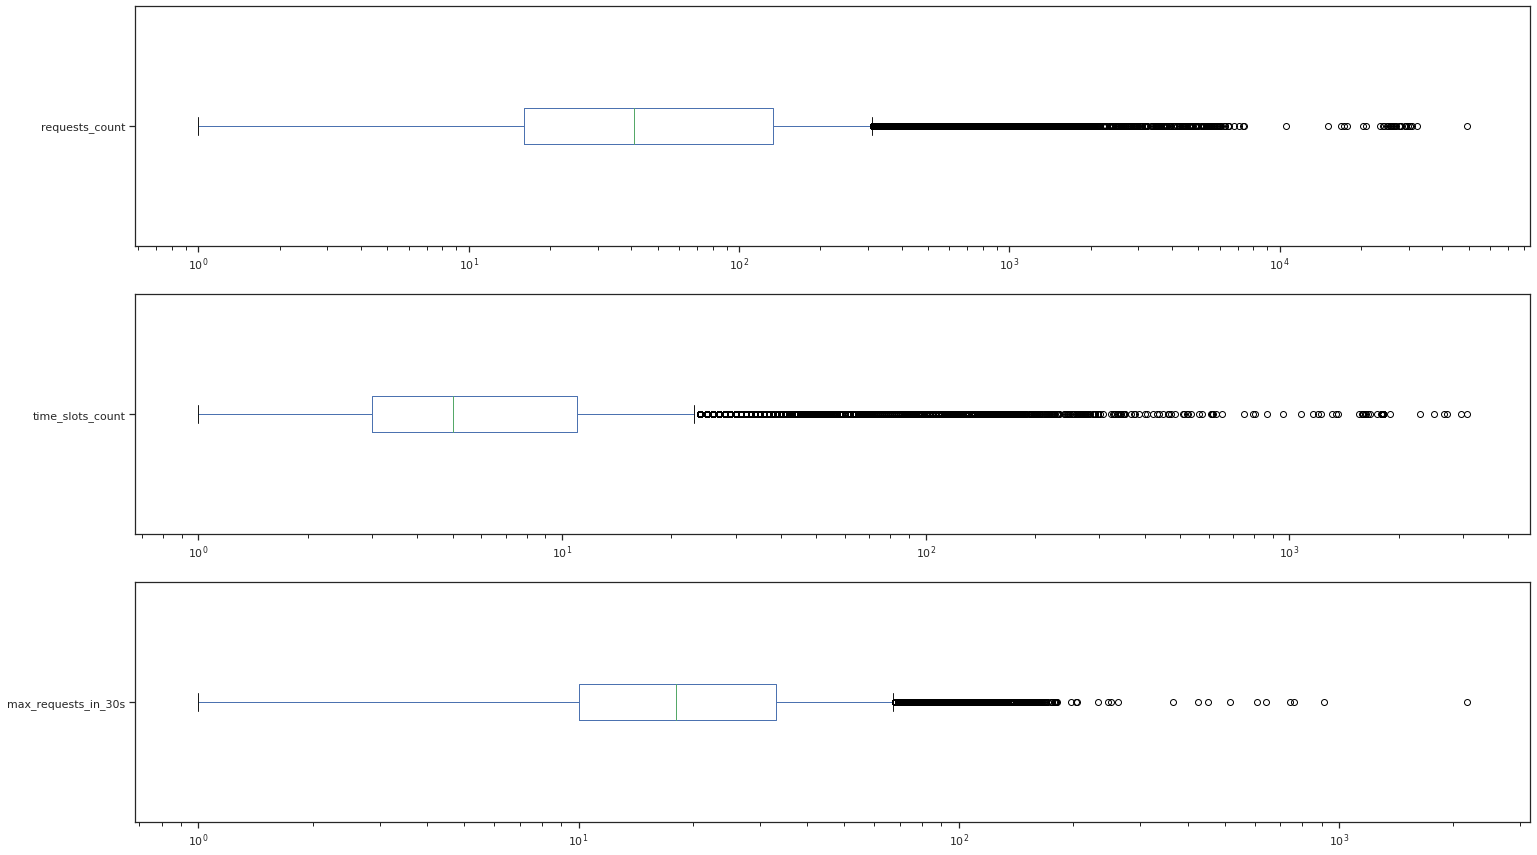

In [27]:

fig=plt.figure(figsize=(25, 15))

fig.add_subplot(3, 1, 1)
clients_statistic['requests_count'].plot(kind='box', vert=False, logx=True)
fig.add_subplot(3, 1, 2)
clients_statistic['time_slots_count'].plot(kind='box', vert=False, logx=True)
fig.add_subplot(3, 1, 3)
clients_statistic['max_requests_in_30s'].plot(kind='box', vert=False, logx=True)
plt.show()

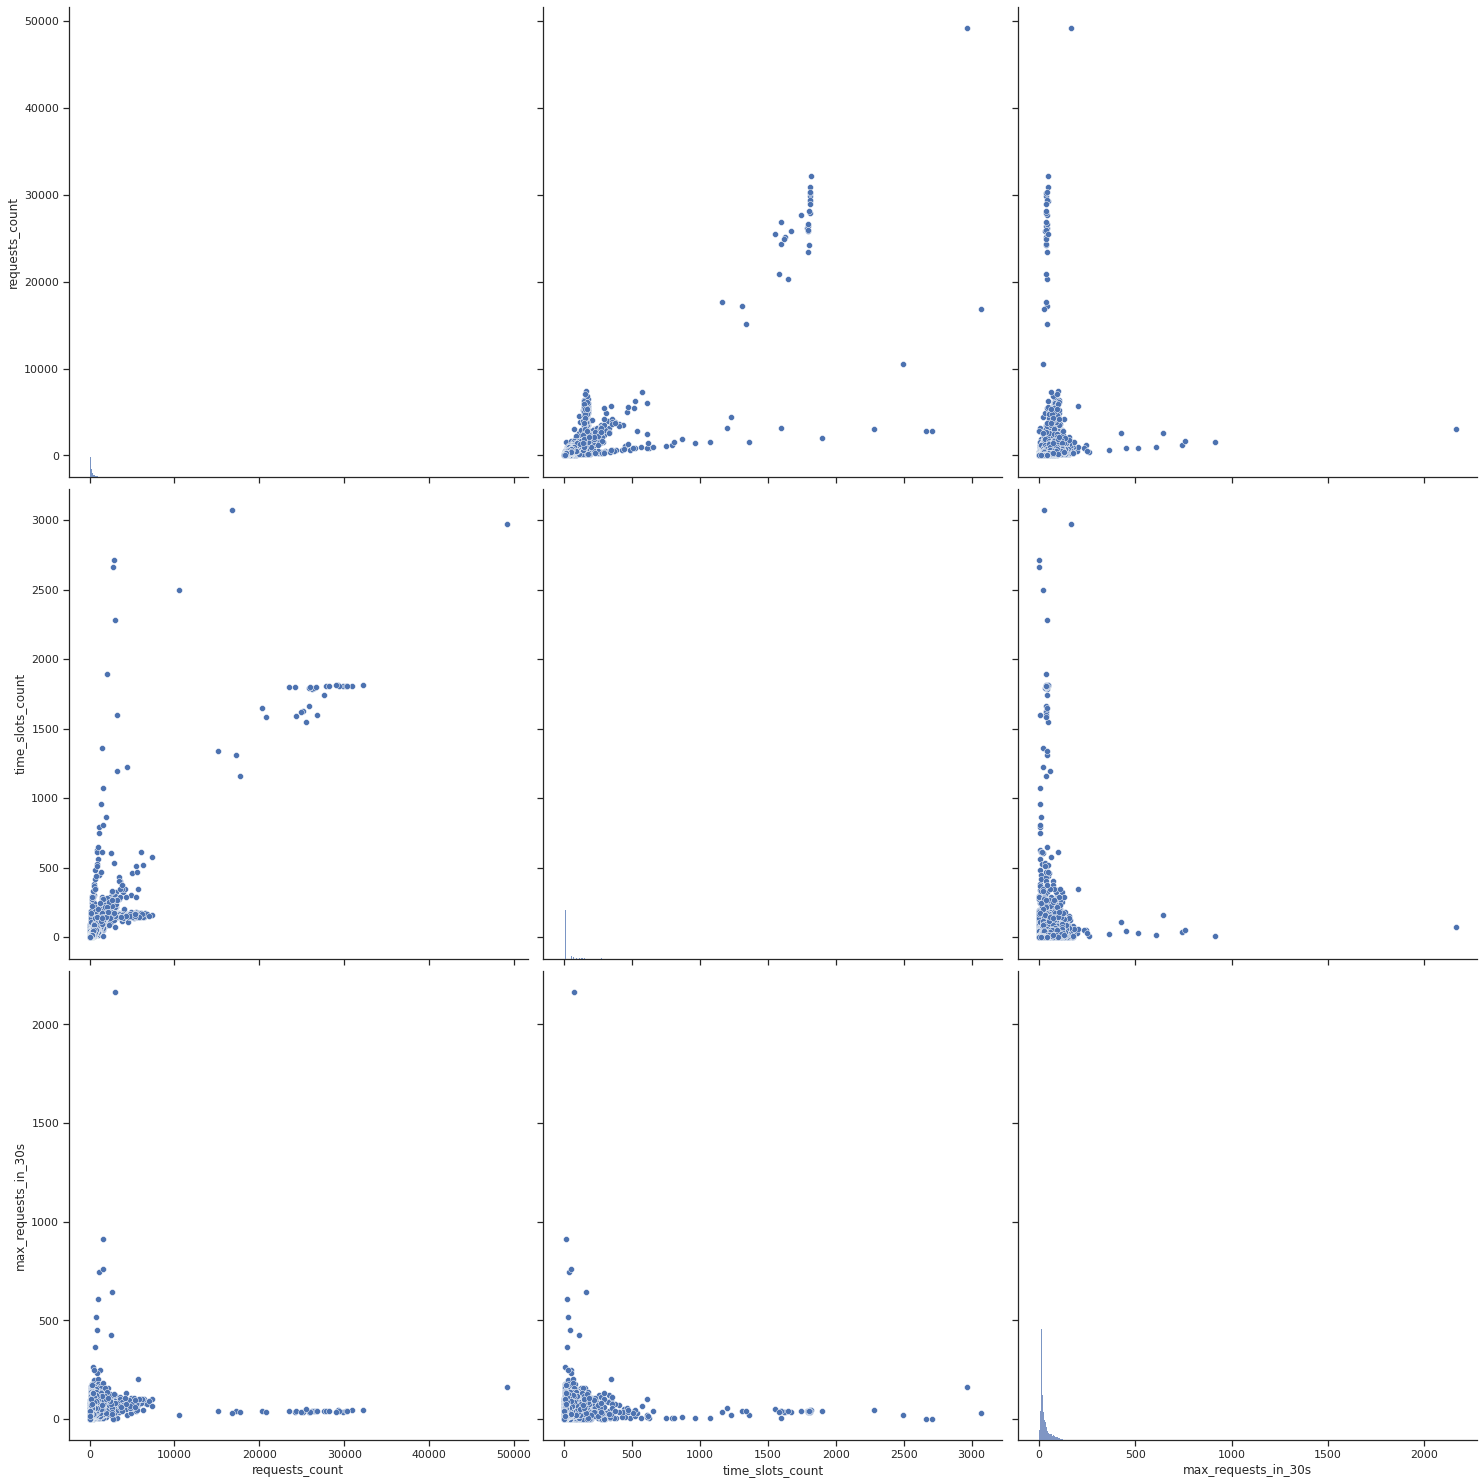

In [28]:
# We will build paired graphs that allow us to establish mutual relationships 
# between different statistical parameters, as well as histograms

cols = ["requests_count", "time_slots_count", "max_requests_in_30s"]
sns_plot = sns.pairplot(clients_statistic[cols], height=7, )
sns_plot.savefig('/content/drive/My Drive/Colab Notebooks/pairplot.png')

В виду чрезвычайно больших величин выбросов, как в прочем и чрезвычайно большого числа одинаковых малых значений - гистограммы малоинформативны. Парные графики дают горазбо больше полезной информации, и позволяют отмечать взаимное отношение параметров. Например, легко заменить неожиданную линейную структуру на графике "requests_count / time_slots_count". Возможно это 
Мы видим, что абсолютное большинство пользователей:
совершают не более трёхсот запросов в течение тридцати секунд


In [34]:
# используем библиотеку автоматического нормирования данных:
from adjdatatools.preprocessing import AdjustedScaler
from sklearn.model_selection import train_test_split

    
train, test  = train_test_split(clients_statistic, test_size=0.25)

new_scaler = AdjustedScaler()
new_scaler.fit(train)

train_s = new_scaler.transform(train)
test_s = new_scaler.transform(test)

print(train_s)

        max_requests_in_30s  requests_count  time_slots_count
src_ip                                                       
58372                -0.032        0.121685          0.319444
92210                 0.384        0.067083          0.055556
49614                 0.480        0.173167          0.361111
100573               -0.096       -0.027301         -0.055556
3035                 -0.080       -0.021061         -0.027778
...                     ...             ...               ...
63822                -0.136       -0.031201         -0.055556
44836                -0.032       -0.012480         -0.027778
71182                 0.016        0.042902          0.069444
17558                 0.080        0.032761          0.069444
31499                -0.032       -0.004680          0.000000

[80059 rows x 3 columns]


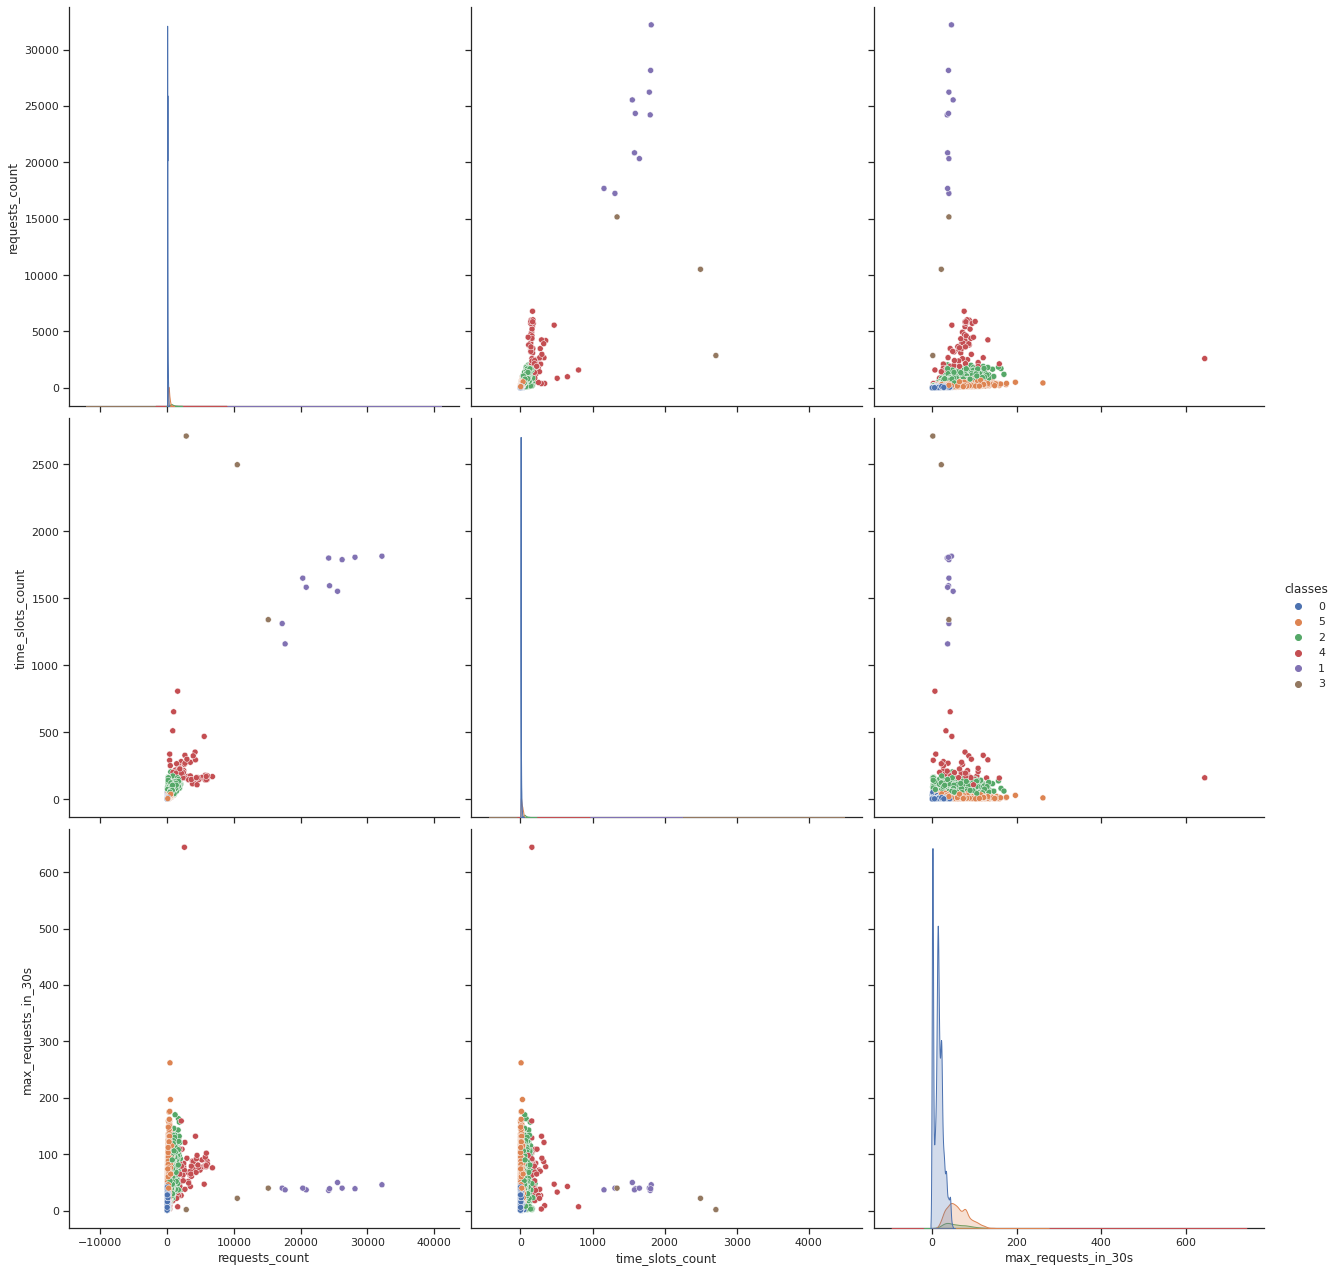

In [36]:
# Импортируем библиотеки
from sklearn import datasets
from sklearn.cluster import KMeans

# Описываем модель
model = KMeans(n_clusters=6)


# Проводим моделирование
model.fit(train_s)

# Предсказание на тестовом наборе данных
test_classes = model.predict(test_s)
test_for_plot = test.copy()
test_for_plot["classes"] = test_classes.astype("str")
# Выводим предсказания с помошью графиков:
cols = ["requests_count", "time_slots_count", "max_requests_in_30s", 'classes']
sns.set(style="ticks", color_codes=True)
sns_plot = sns.pairplot(test_for_plot[cols], height=6, hue="classes")
sns_plot.savefig('/content/drive/My Drive/Colab Notebooks/pairplot.png')